# 🌍 Air Quality Prediction in Moroccan Cities
### Project: Machine Learning + (Optionnel) Federated Learning
**Cities**: Casablanca, Rabat, Marrakech, Fes


**Objectif** : Prédire la qualité de l'air (PM2.5 ou AQI) à partir de données météorologiques collectées en temps réel via l'API OpenWeatherMap.

# 📦 Import des bibliothèques nécessaires,

-pandas/numpy : Manipulation et traitement des données 

-matplotlib/seaborn : Visualisation des données et résultats

-sklearn : Outils d'apprentissage automatique (modèles, métriques, préprocessing)

-requests : Appels API pour récupérer les données météo

-time : Gestion des pauses entre les appels API

In [1]:
# 📦 Import des bibliothèques nécessaires,
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import requests
import json
import time

## 📥 Étape 1 : Collecte de données depuis OpenWeatherMap API

-Définition de la clé API OpenWeatherMap

-Coordonnées géographiques (latitude/longitude) des villes marocaines ciblées

Deux API distinctes : une pour la météo, une pour la pollution

Variables collectées :

Météo : température, humidité, pression, vitesse du vent
Pollution : PM2.5 (particules fines), AQI (indice de qualité de l'air)

Retour structuré sous forme de dictionnaire

Collecte répétée (5 fois) pour chaque ville

Gestion des erreurs avec try/except

Pause entre les appels pour respecter les limites de l'API

In [ ]:
# 🔑 Clé API et coordonnées géographiques des villes
API_KEY = "89671fae7b1780e970a3c9bd8b2eeeb2"

cities = {
  "Casablanca": {"lat": 33.5731, "lon": -7.5898},
  "Rabat": {"lat": 34.0209, "lon": -6.8416},
  "Marrakech": {"lat": 31.6295, "lon": -7.9811},
}

def fetch_data(city, lat, lon):
  weather_url = f"http://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&appid={API_KEY}&units=metric"
  air_url = f"http://api.openweathermap.org/data/2.5/air_pollution?lat={lat}&lon={lon}&appid={API_KEY}"
  
  weather_data = requests.get(weather_url).json()
  air_data = requests.get(air_url).json()
  
  return {
    "city": city,
    "timestamp": pd.Timestamp.now(),
    "temperature": weather_data['main']['temp'],
    "humidity": weather_data['main']['humidity'],
    "pressure": weather_data['main']['pressure'],
    "wind_speed": weather_data['wind']['speed'],
    "pm2_5": air_data['list'][0]['components']['pm2_5'],
    "aqi": air_data['list'][0]['main']['aqi']
  }

# Exemple de collecte (répéter pour plusieurs timestamps)

records = []
for _ in range(5):  # nombre de passages pour simuler plusieurs mesures
  for city, coords in cities.items():
    try:
      record = fetch_data(city, coords['lat'], coords['lon'])
      records.append(record)
    except Exception as e:
      print(f"Erreur pour {city}: {e}")
  time.sleep(60)  # attendre une minute entre les appels

Conversion en DataFrame pandas

Sauvegarde en fichier CSV

In [ ]:
# 📄 Convertir en DataFrame et sauvegarder\n",
df = pd.DataFrame(records)
df.to_csv("./data/air_quality_data.csv", index=False)
df.head()

,city,timestamp,temperature,humidity,pressure,wind_speed,pm2_5,aqi
0,Casablanca,2025-06-16 11:09:36.901594,25.01,69,1016,1.54,13.86,2
1,Rabat,2025-06-16 11:09:37.226359,25.37,73,1016,2.57,14.08,2
2,Marrakech,2025-06-16 11:09:37.518670,26.98,57,1016,1.54,23.19,4
3,Casablanca,2025-06-16 11:10:38.012758,25.01,69,1016,1.54,13.86,2
4,Rabat,2025-06-16 11:10:38.522396,25.37,73,1016,2.57,14.08,2


## 🧹 Étape 2 : Préparation et traitement des données

Suppression des doublons et valeurs manquantes

Encodage des noms de villes en valeurs numériques (nécessaire pour ML)

Suppression des doublons et valeurs manquantes

Encodage des noms de villes en valeurs numériques (nécessaire pour ML)

StandardScaler : normalise les données (moyenne=0, écart-type=1)

train_test_split : divise les données (80% entraînement, 20% test)

In [4]:
# 🧽 Nettoyage
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
df['city'] = LabelEncoder().fit_transform(df['city'])

# 🔄 Séparation features/target
X = df.drop(columns=['pm2_5', 'timestamp'])
y = df['pm2_5']  # Target: PM2.5

# 🔢 Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🧪 Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## 🤖 Étape 3 : Entraînement des modèles de prédiction

Modèle 1 : Régression Linéaire

Modèle simple qui trouve une relation linéaire entre variables météo et PM2.5

In [5]:
# 🔁 Modèle 1 : Régression Linéaire\n",
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)


Modèle 2 : Random Forest

Modèle plus complexe basé sur 100 arbres de décision

Capable de capturer des relations non-linéaires

In [6]:
# 🌲 Modèle 2 : Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

### 📊 Évaluation des modèle

Métriques utilisées :

-MAE : Erreur absolue moyenne

-RMSE : Racine de l'erreur quadratique moyenne

-R² : Coefficient de détermination (qualité de l'ajustement)

In [7]:
def evaluate(y_true, y_pred, name):
  print(f"\n{name}:")
  print("MAE:", mean_absolute_error(y_true, y_pred))
  print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
  print("R2:", r2_score(y_true, y_pred))

evaluate(y_test, y_pred_lr, "Régression Linéaire")
evaluate(y_test, y_pred_rf, "Random Forest")


Régression Linéaire:
MAE: 2.3684757858670005e-15
RMSE: 2.9007785717557725e-15
R2: 1.0

Random Forest:
MAE: 0.15843333333330753
RMSE: 0.16499180787741977
R2: 0.9985927411489408


## 🧪 Bonus : Simulation d’Apprentissage Fédéré (Federated Learning)"

Concept :

L'apprentissage fédéré permet d'entraîner un modèle global sans centraliser les données. Chaque ville (client) entraîne son modèle local, puis les paramètres sont agrégés.

Chaque ville devient un "client" avec ses propres données

Séparation des données par ville

In [ ]:
# 🏛️ Simulation de Federated Learning avec FedAvg
# Préparation des clients (chaque ville = un client)

clients = {}
for city_id in df['city'].unique():
    city_data = df[df['city'] == city_id]
    X_city = scaler.transform(city_data.drop(columns=['pm2_5', 'timestamp']))
    y_city = city_data['pm2_5'].values
    clients[city_id] = (X_city, y_city)


Processus FedAvg :

Entraînement local : Chaque ville entraîne son modèle sur ses données
Envoi des paramètres : Coefficients et intercept envoyés au serveur central
Agrégation : Moyenne pondérée des paramètres selon le nombre d'échantillons
Répétition : Processus répété sur plusieurs rounds

In [ ]:
# Simulation FedAvg
coef = np.zeros(X_train.shape[1])
intercept = 0
rounds = 20

for rnd in range(rounds):
    local_coefs, local_intercepts, n_samples = [], [], []
    for cid, (Xc, yc) in clients.items():
        model = LinearRegression()
        model.fit(Xc, yc)
        local_coefs.append(model.coef_)
        local_intercepts.append(model.intercept_)
        n_samples.append(len(Xc))
    coef = np.average(local_coefs, axis=0, weights=n_samples)
    intercept = np.average(local_intercepts, weights=n_samples)

# Modèle fédéré global
federated_model = LinearRegression()
federated_model.coef_ = coef
federated_model.intercept_ = intercept

Visualisations

Le code génère plusieurs graphiques :

Barplots : Comparaison des métriques (MAE, RMSE, R²)

Scatter plots : Prédictions vs valeurs réelles pour chaque modèle

In [9]:
# Modèles classiques
lr_model = LinearRegression().fit(X_train, y_train)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train, y_train)

# Prédictions
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_fed = federated_model.predict(X_test)

# Fonction d'évaluation
def evaluate_all():
    models = ['Régression Linéaire', 'Random Forest', 'Fédéré']
    predictions = [y_pred_lr, y_pred_rf, y_pred_fed]
    metrics = {'Model': [], 'MAE': [], 'RMSE': [], 'R2': []}

    for name, pred in zip(models, predictions):
        metrics['Model'].append(name)
        metrics['MAE'].append(mean_absolute_error(y_test, pred))
        metrics['RMSE'].append(np.sqrt(mean_squared_error(y_test, pred)))
        metrics['R2'].append(r2_score(y_test, pred))
    
    return metrics

results = evaluate_all()

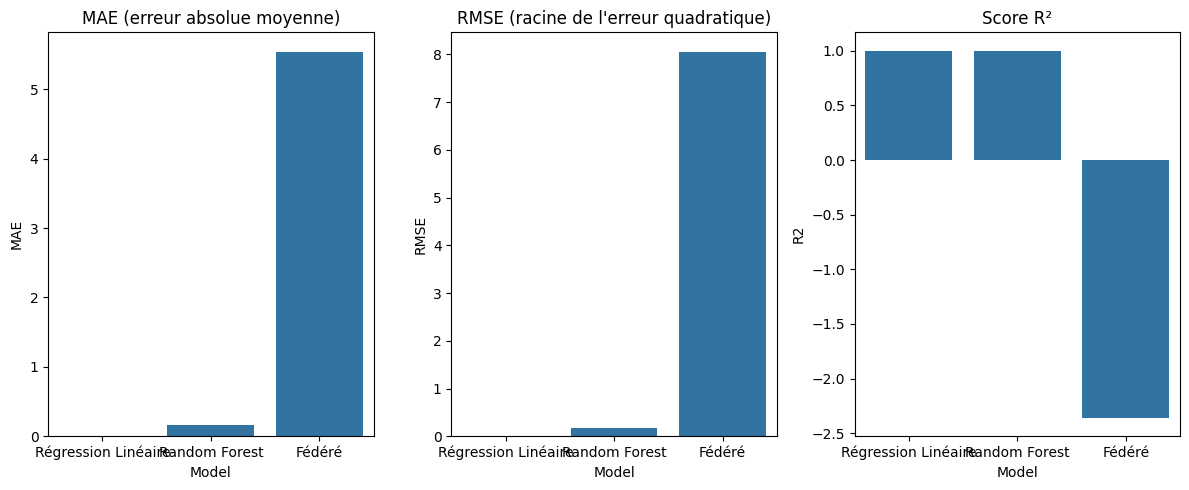

In [10]:
results_df = pd.DataFrame(results)

# Barplot des performances
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
sns.barplot(data=results_df, x="Model", y="MAE")
plt.title("MAE (erreur absolue moyenne)")

plt.subplot(1, 3, 2)
sns.barplot(data=results_df, x="Model", y="RMSE")
plt.title("RMSE (racine de l'erreur quadratique)")

plt.subplot(1, 3, 3)
sns.barplot(data=results_df, x="Model", y="R2")
plt.title("Score R²")

plt.tight_layout()
plt.show()


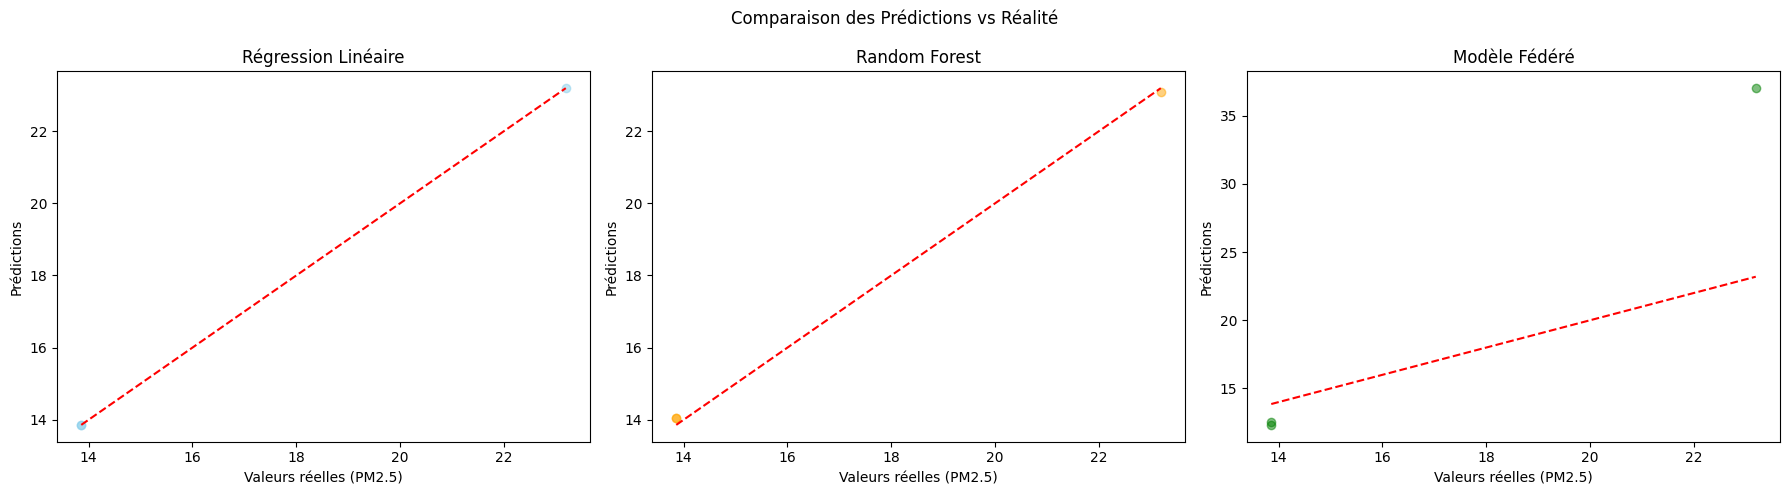

In [11]:
plt.figure(figsize=(18, 5))

# Régression linéaire
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_lr, alpha=0.5, color='skyblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valeurs réelles (PM2.5)")
plt.ylabel("Prédictions")
plt.title("Régression Linéaire")

# Random Forest
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valeurs réelles (PM2.5)")
plt.ylabel("Prédictions")
plt.title("Random Forest")

# Modèle Fédéré
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred_fed, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valeurs réelles (PM2.5)")
plt.ylabel("Prédictions")
plt.title("Modèle Fédéré")

plt.suptitle("Comparaison des Prédictions vs Réalité")
plt.tight_layout()
plt.show()


In [12]:
# 🎓 Regrouper les données par ville (clients)
clients = {}
for city_id in df['city'].unique():
  city_data = df[df['city'] == city_id]
  X_city = scaler.transform(city_data.drop(columns=['pm2_5', 'timestamp']))
  y_city = city_data['pm2_5'].values
  clients[city_id] = (X_city, y_city)

# ⚙️ Initialisation du modèle global (Linear Regression)
global_model = LinearRegression()
coef = np.zeros(X_train.shape[1])
intercept = 0

# 🔄 Fédérer pendant plusieurs rounds
for rnd in range(50):
  print(f"Round {rnd+1}")
  local_coefs = []
  local_intercepts = []
  n_samples = []
  
  for cid, (Xc, yc) in clients.items():
    model = LinearRegression()
    model.fit(Xc, yc)
    local_coefs.append(model.coef_)
    local_intercepts.append(model.intercept_)
    n_samples.append(len(Xc))
    
  # Agrégation FedAvg
  total = np.sum(n_samples)
  coef = np.average(local_coefs, axis=0, weights=n_samples)
  intercept = np.average(local_intercepts, weights=n_samples)

global_model.coef_ = coef
global_model.intercept_ = intercept

y_pred_fed = global_model.predict(X_test)
evaluate(y_test, y_pred_fed, "Modèle Fédéré")

Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10
Round 11
Round 12
Round 13
Round 14
Round 15
Round 16
Round 17
Round 18
Round 19
Round 20
Round 21
Round 22
Round 23
Round 24
Round 25
Round 26
Round 27
Round 28
Round 29
Round 30
Round 31
Round 32
Round 33
Round 34
Round 35
Round 36
Round 37
Round 38
Round 39
Round 40
Round 41
Round 42
Round 43
Round 44
Round 45
Round 46
Round 47
Round 48
Round 49
Round 50

Modèle Fédéré:
MAE: 5.5426842030997365
RMSE: 8.060667857663539
R2: -2.3588551768266495
